# Data Analysis

In [138]:
%matplotlib inline

import pandas as pd
import numpy as np

# sort dictonary values
import operator

# library to handle JSON files
import json 

# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim 

# library to handle requests
import requests 

# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

# for classification
from sklearn.linear_model import LogisticRegression

# for scaling the data
from sklearn.preprocessing import StandardScaler

#!conda install -c conda-forge folium=0.5.0 --yes
# map rendering library
import folium 

# creating heatmaps
from folium import plugins
from folium.plugins import HeatMap

## Importing the datasets

In [2]:
df_l = pd.read_csv("london_areas_latlong.csv")
df_f = pd.read_csv("frankfurt_boroughs_latlong.csv")
df_l.head()

,Area,Latitude,Longitude
0,Abbey Wood,51.487621,0.114050
1,Acton,51.508140,-0.273261
2,Addington,51.358636,-0.031635
3,Addiscombe,51.379692,-0.074282
4,Albany Park,51.435384,0.125965


In [3]:
df_l.isna().any()
#df_l.dropna(inplace=True)
df_l.shape

(522, 3)

## Creating a Map of London and Frankfurt

Now let's visualize the areas we are going to explore.

### London

In [4]:
address = 'London, England, Great Britain'

geolocator = Nominatim(user_agent="l_explorer")
location = geolocator.geocode(address)
latitude_l = location.latitude
longitude_l = location.longitude
print(f'The geograpical coordinate of London are {latitude_l}, {longitude_l}.')

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [54]:
# create map of London using latitude and longitude values
map_london = folium.Map(location=[latitude_l, longitude_l], zoom_start=10)

# add markers to map
for lat, lng, area in zip(df_l['Latitude'], df_l['Longitude'], df_l['Area']):
    label = '{}'.format(area)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

### Frankfurt

In [6]:
address = 'Frankfurt, Hessen, Germany'

geolocator = Nominatim(user_agent="f_explorer")
location = geolocator.geocode(address)
latitude_f = location.latitude
longitude_f = location.longitude
print(f'The geograpical coordinate of Frankfurt are {latitude_f}, {longitude_f}.')

The geograpical coordinate of Frankfurt are 50.1106444, 8.6820917.


In [7]:
# create map of Frankfurt using latitude and longitude values
map_frankfurt = folium.Map(location=[latitude_f, longitude_f], zoom_start=10)

# add markers to map
for lat, lng, borough in zip(df_f['Latitude'], df_f['Longitude'], df_f['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_frankfurt)  
    
map_frankfurt

## Defining the areas we want to explore

Our neighborhoods will be defined as circular areas with a radius of 500 meters. We are interested in the venues in those areas, but first let' visualize the areas and their radius.

### London

In [8]:
# map of areas we are going to explore. The radius is 500m from the center of the area
map_london = folium.Map(location=[latitude_l, longitude_l], zoom_start=10)

# add markers to map
for lat, lng, area in zip(df_l['Latitude'], df_l['Longitude'], df_l['Area']):
    label = '{}'.format(area)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=500,
        popup=label,
        color='green',
        fill=True,
        fill_color='#CAFF70',
        fill_opacity=0.3,
        parse_html=False).add_to(map_london)  
    
map_london

### Frankfurt

In [9]:
# create map of Frankfurt using latitude and longitude values
map_frankfurt = folium.Map(location=[latitude_f, longitude_f], zoom_start=10)

# add markers to map
for lat, lng, area in zip(df_f['Latitude'], df_f['Longitude'], df_f['Borough']):
    label = '{}'.format(area)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius=500,
        popup=label,
        color='green',
        fill=True,
        fill_color='#CAFF70',
        fill_opacity=0.3,
        parse_html=False).add_to(map_frankfurt)  
    
map_frankfurt

## Venue Data

Now we are goign to use the foursquare API to fetch data about the top 100 venues of every area. First we need to define the credentials we need to get access to the foursquare API.

In [10]:
CLIENT_ID = 'G0EDQTSKXYGO4PAYI14O2I0FUVWOU1ZSADJKFIFZAJDW3DB0'
CLIENT_SECRET = 'GZT4BQDW1Z0DFAM1RY3SQ1QPN4UIDPBFQBXVJC00YJ02FABI'
VERSION = '20180604' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: G0EDQTSKXYGO4PAYI14O2I0FUVWOU1ZSADJKFIFZAJDW3DB0
CLIENT_SECRET:GZT4BQDW1Z0DFAM1RY3SQ1QPN4UIDPBFQBXVJC00YJ02FABI


In [11]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [12]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        except:
            print("ERROR:",requests.get(url).json())
            return 

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Area', 
                  'Area Latitude', 
                  'Area Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Getting the venues for Frankfurt

In [13]:
frankfurt_venues = getNearbyVenues(names=df_f['Borough'],
                                   latitudes=df_f['Latitude'],
                                   longitudes=df_f['Longitude'],
                                   radius=500  
                                  )

In [14]:
venue_backup_f = frankfurt_venues

In [15]:
print(frankfurt_venues.shape)
frankfurt_venues.head()

(801, 7)


,Area,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Altstadt,50.110442,8.682901,Römerberg,50.110489,8.682131,Plaza
1,Altstadt,50.110442,8.682901,SCHIRN Kunsthalle,50.110291,8.683542,Art Museum
2,Altstadt,50.110442,8.682901,Dom Aussichtsplattform,50.110609,8.684908,Scenic Lookout
3,Altstadt,50.110442,8.682901,Weinterasse Rollanderhof,50.112473,8.682164,Wine Bar
4,Altstadt,50.110442,8.682901,Main,50.108390,8.682631,River


### Number of Venues per area

In [16]:
frankfurt_distrib = frankfurt_venues.groupby('Area').count()
frankfurt_distrib.drop(frankfurt_distrib.columns.difference(['Area Latitude']), 1, inplace=True)
frankfurt_distrib.columns = ['Distribution']
frankfurt_distrib.mean()

Distribution    17.413043
dtype: float64

In [55]:
frankfurt_distrib.head()

,Distribution
Area,
Altstadt,92
Bahnhofsviertel,100
Berkersheim,3
Bockenheim,25
Bonames,8


Text(0.5, 0, 'Number of Venues')

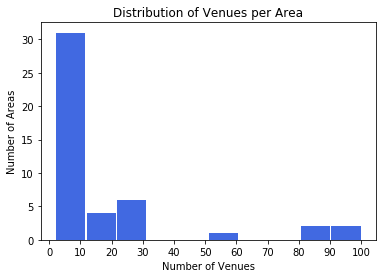

In [79]:
frankfurt_distrib["Distribution"].plot(kind="hist", rwidth=.95, color="royalblue")
plt.xticks([10 * i for i in range(11)])
plt.title("Distribution of Venues per Area")
plt.ylabel("Number of Areas")
plt.xlabel("Number of Venues")

## Distribution of the venues in Frankfurt

In [94]:

map_frankfurt_heat = folium.Map(location=[latitude_f, longitude_f], zoom_start = 11) 

# Ensure you're handing it floats
frankfurt_venues['Venue Latitude'] = frankfurt_venues['Venue Latitude'].astype(float)
frankfurt_venues['Venue Longitude'] = frankfurt_venues['Venue Longitude'].astype(float)

# Filter the DF for rows, then columns, then remove NaNs
heat_df = frankfurt_venues[['Venue Latitude', 'Venue Longitude']]
heat_df = heat_df.dropna(axis=0, subset=['Venue Latitude','Venue Longitude'])

# List comprehension to make out list of lists
heat_data = [[row['Venue Latitude'],row['Venue Longitude']] for index, row in heat_df.iterrows()]

# Plot it on the map
HeatMap(heat_data, radius=15).add_to(map_frankfurt_heat)

# Display the map
map_frankfurt_heat

## Location of the venues in "Bahnhofsviertel"

In [61]:
bhvrtl_venues = frankfurt_venues.loc[frankfurt_venues['Area'] == "Bahnhofsviertel"]

In [70]:
# create map of Frankfurt using latitude and longitude values
latitude_bhvrtl = 50.107741
longitude_bhvrtl = 8.668676
map_bhvrtl = folium.Map(location=[latitude_bhvrtl, longitude_bhvrtl], zoom_start=15)

# add borough radius to the map
folium.Circle(
    [latitude_bhvrtl, longitude_bhvrtl],
    radius=500,
    popup=label,
    color='green',
    fill=True,
    fill_color='#CAFF70',
    fill_opacity=0.3,
    parse_html=False).add_to(map_bhvrtl)  

# add venue markers to map
for lat, lng, cat, name in zip(bhvrtl_venues['Venue Latitude'], bhvrtl_venues['Venue Longitude'], bhvrtl_venues['Venue Category'], bhvrtl_venues['Venue']):
    #label = '{}'.format(area)
    label = folium.Popup(name + ' Category ' + cat, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='red',
        fill=True,
        fill_color='#FF0000',
        fill_opacity=0.3,
        parse_html=False).add_to(map_bhvrtl)
    

    
map_bhvrtl

### Insights about the venues

Let's check out how many different venue categories we have.

In [18]:
print('There are {} uniques categories.'.format(len(frankfurt_venues['Venue Category'].unique())))

There are 180 uniques categories.


### Analysing each area

In [126]:
# one hot encoding
frankfurt_onehot = pd.get_dummies(frankfurt_venues[['Venue Category']], prefix="", prefix_sep="")

# add area column back to dataframe
frankfurt_onehot['Area'] = frankfurt_venues['Area'] 

# move frankfrtt column to the first column
fixed_columns = [frankfurt_onehot.columns[-1]] + list(frankfurt_onehot.columns[:-1])
frankfurt_onehot = frankfurt_onehot[fixed_columns]

frankfurt_onehot.head()

,Area,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Apple Wine Pub,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,...,Train Station,Tram Station,Transportation Service,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar
0,Altstadt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Altstadt,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Altstadt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Altstadt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,Altstadt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Checkout the new size.

In [130]:
frankfurt_onehot.shape

(801, 181)

### Top 10 venues per city

In [190]:
def get_top_10_venues_city(df):
    df_copy = df.copy()
    dicti = {}
    df_copy.drop(columns="Area", inplace=True)
    
    for element in df_copy.columns:
        dicti.update( {element : df_copy[element].sum()})
    
    sorted_d = dict( sorted(dicti.items(), key=operator.itemgetter(1),reverse=True))
    #print(sorted_d.items())
    #print('Dictionary in descending order by value : ',sorted_d)
    items = list(sorted_d.items())
    top_10 = []
    for i in range(10):
        top_10.append(items[i])
    
    df_res = pd.DataFrame(top_10, columns=['Venue', 'Number of occurrences'])
    df_res.set_index('Venue', inplace=True)
    return df_res

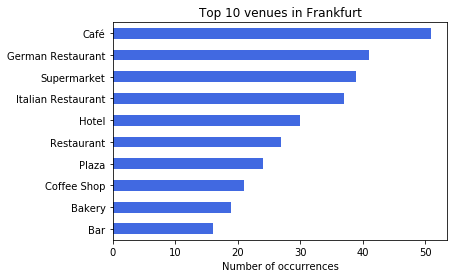

In [199]:
top_10_venues_frankfurt = get_top_10_venues_city(frankfurt_onehot)

top_10_venues_frankfurt.plot(kind="barh", color="royalblue")
plt.title("Top 10 venues in Frankfurt")
plt.xlabel("Number of occurrences")
plt.ylabel("")
plt.legend().remove()
plt.gca().invert_yaxis()
plt.show()

### Top 10 venues per area

Next, we group the rows by area and by taking the mean of the frequency of occurence of each category.

In [97]:
frankfurt_grouped = frankfurt_onehot.groupby('Area').mean().reset_index()
frankfurt_grouped.head()

,Area,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Apple Wine Pub,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,...,Train Station,Tram Station,Transportation Service,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar
0,Altstadt,0.00,0.0,0.0,0.0,0.0,0.0,0.043478,0.00,0.0,...,0.0,0.0,0.0,0.0,0.00,0.00,0.01087,0.00,0.00,0.021739
1,Bahnhofsviertel,0.01,0.0,0.0,0.0,0.0,0.0,0.010000,0.01,0.0,...,0.0,0.0,0.0,0.0,0.00,0.01,0.03000,0.01,0.01,0.010000
2,Berkersheim,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,...,0.0,0.0,0.0,0.0,0.00,0.00,0.00000,0.00,0.00,0.000000
3,Bockenheim,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.12,0.0,...,0.0,0.0,0.0,0.0,0.04,0.00,0.00000,0.00,0.00,0.040000
4,Bonames,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,...,0.0,0.0,0.0,0.0,0.00,0.00,0.00000,0.00,0.00,0.000000


Let's print each area with the top 5 most common venues.

In [22]:
num_top_venues = 5

for hood in frankfurt_grouped['Area']:
    print("----"+hood+"----")
    temp = frankfurt_grouped[frankfurt_grouped['Area'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Altstadt----
          venue  freq
0          Café  0.10
1         Plaza  0.05
2    Restaurant  0.05
3    Art Museum  0.04
4  Burger Joint  0.04


----Bahnhofsviertel----
               venue  freq
0              Hotel  0.11
1  Indian Restaurant  0.06
2                Bar  0.05
3         Restaurant  0.04
4               Café  0.04


----Berkersheim----
                        venue  freq
0           German Restaurant  0.33
1  Construction & Landscaping  0.33
2              Shipping Store  0.33
3                        Park  0.00
4                      Museum  0.00


----Bockenheim----
                       venue  freq
0                       Café  0.16
1           Asian Restaurant  0.12
2             Ice Cream Shop  0.08
3                   Wine Bar  0.04
4  Middle Eastern Restaurant  0.04


----Bonames----
                venue  freq
0  Italian Restaurant  0.12
1    Doner Restaurant  0.12
2               Diner  0.12
3                Café  0.12
4      Ice Cream Shop  0.12


----Bo

Let's safe this in a dataframe and start with a function to sort the venues in a descending order

In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighbourhood

In [217]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Borough'] = frankfurt_grouped['Area']

for ind in np.arange(frankfurt_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(frankfurt_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Altstadt,Café,Plaza,Restaurant,German Restaurant,Art Museum,Burger Joint,Coffee Shop,Bistro,History Museum,Italian Restaurant
1,Bahnhofsviertel,Hotel,Indian Restaurant,Bar,Bakery,Restaurant,Café,Chinese Restaurant,Seafood Restaurant,Vietnamese Restaurant,Burger Joint
2,Berkersheim,German Restaurant,Construction & Landscaping,Farmers Market,Garden,Furniture / Home Store,French Restaurant,Fountain,Food Court,Food & Drink Shop,Food
3,Bockenheim,Café,Asian Restaurant,Ice Cream Shop,Supermarket,Hookah Bar,Gym,Greek Restaurant,Metro Station,Middle Eastern Restaurant,Department Store
4,Bonames,Diner,Doner Restaurant,Café,Metro Station,Bakery,German Restaurant,Ice Cream Shop,Italian Restaurant,Electronics Store,Food Court


## Clustering the data (Frankfurt)

Now we want to group the different areas of frankfurt who are quit similiar. To find the best number of different clusters, we are going to use the elbow method.

In [25]:
# Data we are going to use
frankfurt_grouped_clustering = frankfurt_grouped.drop('Area', 1)
frankfurt_grouped_clustering.head()

,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Apple Wine Pub,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Austrian Restaurant,...,Train Station,Tram Station,Transportation Service,Trattoria/Osteria,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar
0,0.00,0.0,0.0,0.0,0.0,0.0,0.043478,0.00,0.0,0.01087,...,0.0,0.0,0.0,0.0,0.00,0.00,0.01087,0.00,0.00,0.021739
1,0.01,0.0,0.0,0.0,0.0,0.0,0.010000,0.01,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.00,0.01,0.03000,0.01,0.01,0.010000
2,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.00,0.00,0.00000,0.00,0.00,0.000000
3,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.12,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.04,0.00,0.00000,0.00,0.00,0.040000
4,0.00,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.00,0.00,0.00000,0.00,0.00,0.000000


KMeans elbow method:

In [26]:
distortions = []
K = range(1,47)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(frankfurt_grouped_clustering)
    distortions.append(kmeanModel.inertia_)

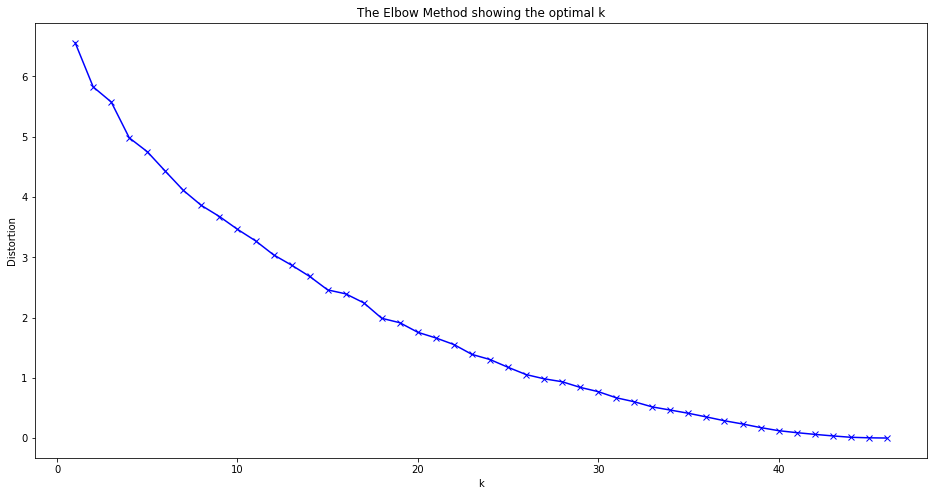

In [27]:
# Plot the elbow method
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### Run KMeans with [value]

In [28]:
# set number of clusters
kclusters = 46

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(frankfurt_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([45, 43, 11, 42,  6, 37, 15, 23,  7, 17])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each area.

In [29]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

frankfurt_merged = df_f

# merge frankfurt_grouped with frankfurt_data to add latitude/longitude for each neighborhood
frankfurt_merged = frankfurt_merged.join(neighborhoods_venues_sorted.set_index('Area'), on='Borough')

frankfurt_merged.head() # check the last columns!

,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Altstadt,50.110442,8.682901,45.0,Café,Plaza,Restaurant,German Restaurant,Art Museum,Burger Joint,Coffee Shop,Bistro,History Museum,Italian Restaurant
1,Innenstadt,50.112993,8.674341,44.0,Coffee Shop,German Restaurant,Hotel,Café,Plaza,Boutique,Department Store,Steakhouse,Bar,Restaurant
2,Bahnhofsviertel,50.107741,8.668676,43.0,Hotel,Indian Restaurant,Bar,Restaurant,Bakery,Café,Chinese Restaurant,Seafood Restaurant,Vietnamese Restaurant,Cocktail Bar
3,Westend-Süd,50.115245,8.662270,0.0,Italian Restaurant,Steakhouse,Bakery,Convenience Store,Supermarket,Ramen Restaurant,Gym,Gym / Fitness Center,French Restaurant,Bar
4,Westend-Nord,50.126356,8.667921,41.0,Sushi Restaurant,Coffee Shop,Café,Bus Stop,Italian Restaurant,Wine Bar,Park,Ethiopian Restaurant,Cafeteria,Garden


Get rid of wrong values

In [30]:
print(frankfurt_merged.isna().sum())
frankfurt_merged.dropna(inplace=True)
print(frankfurt_merged.shape)
frankfurt_merged.head()

Borough                   0
Latitude                  0
Longitude                 0
Cluster Labels            1
1st Most Common Venue     1
2nd Most Common Venue     1
3rd Most Common Venue     1
4th Most Common Venue     1
5th Most Common Venue     1
6th Most Common Venue     1
7th Most Common Venue     1
8th Most Common Venue     1
9th Most Common Venue     1
10th Most Common Venue    1
dtype: int64
(46, 14)


,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Altstadt,50.110442,8.682901,45.0,Café,Plaza,Restaurant,German Restaurant,Art Museum,Burger Joint,Coffee Shop,Bistro,History Museum,Italian Restaurant
1,Innenstadt,50.112993,8.674341,44.0,Coffee Shop,German Restaurant,Hotel,Café,Plaza,Boutique,Department Store,Steakhouse,Bar,Restaurant
2,Bahnhofsviertel,50.107741,8.668676,43.0,Hotel,Indian Restaurant,Bar,Restaurant,Bakery,Café,Chinese Restaurant,Seafood Restaurant,Vietnamese Restaurant,Cocktail Bar
3,Westend-Süd,50.115245,8.662270,0.0,Italian Restaurant,Steakhouse,Bakery,Convenience Store,Supermarket,Ramen Restaurant,Gym,Gym / Fitness Center,French Restaurant,Bar
4,Westend-Nord,50.126356,8.667921,41.0,Sushi Restaurant,Coffee Shop,Café,Bus Stop,Italian Restaurant,Wine Bar,Park,Ethiopian Restaurant,Cafeteria,Garden


Finally, let's visualize the resulting clusters

In [31]:
# create map
map_clusters_f = folium.Map(location=[latitude_f, longitude_f], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(frankfurt_merged['Latitude'], frankfurt_merged['Longitude'], frankfurt_merged['Borough'], frankfurt_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters_f)
       
map_clusters_f

In [32]:
len(frankfurt_merged["Cluster Labels"].unique())

46

### Getting the venues for London

In [33]:
london_venues = getNearbyVenues(names=df_l['Area'],
                                   latitudes=df_l['Latitude'],
                                   longitudes=df_l['Longitude'],
                                   radius=500  
                                  )

In [34]:
venue_backup_l = london_venues

In [35]:
print(london_venues.shape)
london_venues.head()

(12518, 7)


,Area,Area Latitude,Area Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abbey Wood,51.487621,0.114050,Co-op Food,51.487650,0.113490,Grocery Store
1,Abbey Wood,51.487621,0.114050,Bostal Gardens,51.486670,0.110462,Playground
2,Abbey Wood,51.487621,0.114050,Costcutter,51.487031,0.108221,Convenience Store
3,Abbey Wood,51.487621,0.114050,Abbey Wood Caravan Club,51.485502,0.120014,Campground
4,Acton,51.508140,-0.273261,London Star Hotel,51.509624,-0.272456,Hotel


## Number of venues per area

In [84]:
london_distrib = london_venues.groupby('Area').count()
london_distrib.drop(london_distrib.columns.difference(['Area Latitude']), 1, inplace=True)
london_distrib.columns = ['Distribution']
london_distrib.mean()

Distribution    24.166023
dtype: float64

Text(0.5, 0, 'Number of Venues')

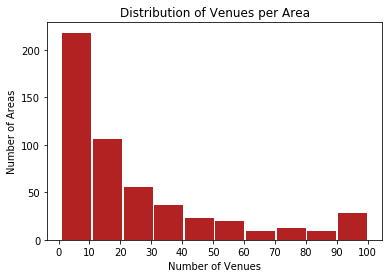

In [82]:
london_distrib["Distribution"].plot(kind="hist", rwidth=.95, color="firebrick")
plt.xticks([10 * i for i in range(11)])
plt.title("Distribution of Venues per Area")
plt.ylabel("Number of Areas")
plt.xlabel("Number of Venues")

## Heatmap of venue distribution in London

In [96]:

map_london_heat = folium.Map(location=[latitude_l, longitude_l], zoom_start = 11) 

# Ensure you're handing it floats
london_venues['Venue Latitude'] = london_venues['Venue Latitude'].astype(float)
london_venues['Venue Longitude'] = london_venues['Venue Longitude'].astype(float)

# Filter the DF for rows, then columns, then remove NaNs
#heat_df = df_acc[df_acc['Speed_limit']=='40'] # Reducing data size so it runs faster
#heat_df = df_acc[df_acc['Year']=='2007'] # Reducing data size so it runs faster
heat_df = london_venues[['Venue Latitude', 'Venue Longitude']]
heat_df = heat_df.dropna(axis=0, subset=['Venue Latitude','Venue Longitude'])

# List comprehension to make out list of lists
heat_data = [[row['Venue Latitude'],row['Venue Longitude']] for index, row in heat_df.iterrows()]

# Plot it on the map
HeatMap(heat_data, radius=12).add_to(map_london_heat)

# Display the map
map_london_heat

### Insights about the venues

In [38]:
print('There are {} uniques categories.'.format(len(london_venues['Venue Category'].unique())))

There are 412 uniques categories.


### Analyzing each area

In [39]:
# one hot encoding
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

# add area column back to dataframe
london_onehot['Area'] = london_venues['Area'] 

# move london column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

london_onehot.head()

,Area,Accessories Store,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,...,Whisky Bar,Windmill,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Abbey Wood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Abbey Wood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Abbey Wood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Abbey Wood,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Acton,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Checkout the new size

In [40]:
london_onehot.shape

(12518, 413)

### Top 10 venues of London

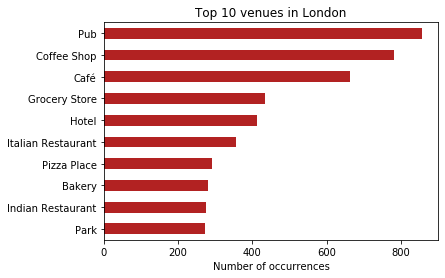

In [201]:
top_10_venues_london = get_top_10_venues_city(london_onehot)

top_10_venues_london.plot(kind="barh", color="firebrick")
plt.title("Top 10 venues in London")
plt.xlabel("Number of occurrences")
plt.ylabel("")
plt.legend().remove()
plt.gca().invert_yaxis()
plt.show()

### Top 10 venues per area

Next, we group the rows by area and by taking the mean of the frequency of occurence of each category.

In [204]:
london_grouped = london_onehot.groupby('Area').mean().reset_index()
london_grouped.head()

,Area,Accessories Store,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,...,Whisky Bar,Windmill,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Abbey Wood,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,Acton,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.047619,0.047619,0.0,0.0,0.0,0.0,0.0,0.0
2,Addington,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,Addiscombe,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,Albany Park,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


Let's print each area with the top 5 most common venues.

In [42]:
num_top_venues = 5

for hood in london_grouped['Area']:
    print("----"+hood+"----")
    temp = london_grouped[london_grouped['Area'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Abbey Wood----
               venue  freq
0  Convenience Store  0.25
1      Grocery Store  0.25
2         Campground  0.25
3         Playground  0.25
4  Accessories Store  0.00


----Acton----
                  venue  freq
0                   Pub  0.19
1  Gym / Fitness Center  0.14
2                 Hotel  0.05
3               Brewery  0.05
4           Supermarket  0.05


----Addington----
                venue  freq
0        Tram Station  0.25
1         Gas Station  0.25
2  English Restaurant  0.25
3         Bus Station  0.25
4   Accessories Store  0.00


----Addiscombe----
                  venue  freq
0                  Park  0.18
1         Grocery Store  0.18
2    Chinese Restaurant  0.09
3                 Diner  0.09
4  Fast Food Restaurant  0.09


----Albany Park----
                   venue  freq
0                    Pub  0.25
1      Indian Restaurant  0.25
2          Grocery Store  0.25
3          Train Station  0.25
4  Portuguese Restaurant  0.00


----Aldgate----
        

          venue  freq
0           Pub  0.18
1   Coffee Shop  0.18
2  Gourmet Shop  0.09
3          Café  0.09
4    Campground  0.09


----Bow----
         venue  freq
0          Pub  0.17
1     Bus Stop  0.17
2          Bar  0.08
3  Art Gallery  0.08
4          Gym  0.08


----Bowes Park----
               venue  freq
0        Coffee Shop  0.25
1                Pub  0.08
2  Indian Restaurant  0.08
3               Café  0.08
4       Gourmet Shop  0.08


----Brent Cross----
              venue  freq
0    Clothing Store  0.12
1       Coffee Shop  0.08
2       Supermarket  0.08
3              Café  0.08
4  Department Store  0.06


----Brent Park----
               venue  freq
0             Bakery  0.25
1        Coffee Shop  0.25
2      Grocery Store  0.25
3    Warehouse Store  0.25
4  Accessories Store  0.00


----Brentford----
                venue  freq
0         Coffee Shop  0.25
1                 Gym  0.17
2         Pizza Place  0.08
3       Deli / Bodega  0.08
4  English Restaurant  0

                        venue  freq
0  Construction & Landscaping  0.67
1          Chinese Restaurant  0.33
2           Accessories Store  0.00
3             Organic Grocery  0.00
4                 Pastry Shop  0.00


----Coney Hall----
            venue  freq
0            Park  0.33
1             Pub  0.17
2      Restaurant  0.17
3   Grocery Store  0.17
4  Hardware Store  0.17


----Coulsdon----
               venue  freq
0        Supermarket  0.25
1                Pub  0.12
2  Martial Arts Dojo  0.12
3      Grocery Store  0.12
4           Pharmacy  0.12


----Covent Garden----
                venue  freq
0             Theater  0.08
1         Coffee Shop  0.05
2      Clothing Store  0.04
3              Bakery  0.04
4  Italian Restaurant  0.03


----Cowley----
               venue  freq
0                Pub  0.14
1               Park  0.14
2          Nightclub  0.14
3  Convenience Store  0.14
4     Sandwich Place  0.14


----Cranford----
               venue  freq
0           Bus Stop 

4             Pizza Place  0.11


----Falconwood----
                venue  freq
0   Other Repair Shop  0.29
1       Train Station  0.14
2            Bus Stop  0.14
3  English Restaurant  0.14
4            Platform  0.14


----Farringdon----
         venue  freq
0          Pub  0.11
1  Coffee Shop  0.08
2     Beer Bar  0.05
3        Hotel  0.05
4         Café  0.05


----Feltham----
                 venue  freq
0          Supermarket  0.10
1          Pizza Place  0.10
2             Pharmacy  0.10
3       Clothing Store  0.10
4  American Restaurant  0.05


----Finchley----
                  venue  freq
0               Brewery  0.25
1  Fast Food Restaurant  0.25
2               Gay Bar  0.25
3  Gym / Fitness Center  0.25
4     Accessories Store  0.00


----Finsbury----
            venue  freq
0             Pub  0.16
1  Sandwich Place  0.06
2     Coffee Shop  0.06
3             Bar  0.05
4            Café  0.05


----Finsbury Park----
           venue  freq
0            Pub  0.11
1  Groce

----Harlesden----
                       venue  freq
0                        Pub  0.17
1        Rental Car Location  0.17
2              Movie Theater  0.17
3  Middle Eastern Restaurant  0.17
4                Auto Garage  0.17


----Harlington----
                  venue  freq
0                   Pub   0.3
1     Indian Restaurant   0.1
2  Fast Food Restaurant   0.1
3         Grocery Store   0.1
4                 Hotel   0.1


----Harmondsworth----
                           venue  freq
0                            Pub  0.67
1                Bed & Breakfast  0.33
2              Accessories Store  0.00
3                   Optical Shop  0.00
4  Paper / Office Supplies Store  0.00


----Harold Hill----
                  venue  freq
0         Grocery Store  0.33
1                Bakery  0.17
2  Fast Food Restaurant  0.17
3                  Pool  0.17
4           Supermarket  0.17


----Harold Park----
           venue  freq
0       Platform  0.43
1       Gym Pool  0.14
2       Bus Stop  0.

4               Park  0.00


----Kew----
              venue  freq
0            Garden  0.20
1  Botanical Garden  0.17
2              Café  0.17
3        Playground  0.10
4    Ice Cream Shop  0.03


----Kidbrooke----
          venue  freq
0          Park  0.17
1  Soccer Field  0.17
2      Bus Stop  0.17
3   Supermarket  0.17
4          Café  0.17


----Kilburn----
                  venue  freq
0     Indian Restaurant  0.11
1                   Pub  0.09
2                  Café  0.06
3  Brazilian Restaurant  0.06
4           Supermarket  0.06


----King's Cross----
          venue  freq
0          Café  0.07
1         Hotel  0.06
2   Coffee Shop  0.06
3  Burger Joint  0.06
4           Pub  0.05


----Kingsbury----
                     venue  freq
0            Grocery Store  0.19
1                      Pub  0.06
2        Indian Restaurant  0.06
3  Fruit & Vegetable Store  0.06
4     Herbs & Spices Store  0.06


----Kingston Vale----
             venue  freq
0     Soccer Field  0.25
1     

4    Restaurant   0.2


----Mottingham----
               venue  freq
0                Bar  0.25
1  Convenience Store  0.25
2          Pet Store  0.25
3                Gym  0.25
4  Accessories Store  0.00


----Muswell Hill----
                venue  freq
0                Café  0.12
1                 Pub  0.06
2         Coffee Shop  0.06
3         Pizza Place  0.06
4  English Restaurant  0.04


----Nag's Head----
            venue  freq
0     Coffee Shop  0.06
1         Theater  0.05
2          Bakery  0.04
3  Clothing Store  0.04
4  Ice Cream Shop  0.04


----Neasden----
                   venue  freq
0          Train Station   0.2
1  Portuguese Restaurant   0.2
2         Sandwich Place   0.2
3               Bus Stop   0.2
4            Supermarket   0.2


----New Addington----
               venue  freq
0       Tram Station  0.25
1        Gas Station  0.25
2  Convenience Store  0.25
3      Grocery Store  0.25
4  Accessories Store  0.00


----New Barnet----
                  venue  fre

               venue  freq
0               Lake   0.2
1               Park   0.2
2  Convenience Store   0.2
3           Bus Stop   0.2
4   Kebab Restaurant   0.2


----Ponders End----
                venue  freq
0       Train Station  0.25
1      Breakfast Spot  0.25
2  English Restaurant  0.25
3       Boat or Ferry  0.25
4   Accessories Store  0.00


----Poplar----
           venue  freq
0           Park  0.08
1     Steakhouse  0.08
2    Coffee Shop  0.08
3  Grocery Store  0.08
4         Tunnel  0.08


----Pratt's Bottom----
                   venue  freq
0                    Bar  0.33
1           Home Service  0.33
2            Coffee Shop  0.33
3      Accessories Store  0.00
4  Performing Arts Venue  0.00


----Preston----
                 venue  freq
0     Asian Restaurant  0.25
1   Italian Restaurant  0.25
2  Sporting Goods Shop  0.25
3          Auto Garage  0.25
4         Optical Shop  0.00


----Primrose Hill----
                venue  freq
0         Zoo Exhibit  0.12
1         

            venue  freq
0     Supermarket  0.17
1   Metro Station  0.06
2  Discount Store  0.06
3  Sandwich Place  0.06
4           Hotel  0.06


----South Tottenham----
            venue  freq
0     Pizza Place  0.17
1   Grocery Store  0.17
2  Hardware Store  0.08
3    Concert Hall  0.08
4     Coffee Shop  0.08


----South Wimbledon----
                 venue  freq
0        Grocery Store  0.12
1          Coffee Shop  0.08
2  Lebanese Restaurant  0.08
3                 Café  0.08
4     Sushi Restaurant  0.08


----South Woodford----
                venue  freq
0       Grocery Store  0.12
1         Supermarket  0.08
2  Italian Restaurant  0.08
3         Coffee Shop  0.08
4                 Bar  0.08


----Southall----
               venue  freq
0  Indian Restaurant  0.53
1     Sandwich Place  0.07
2      Grocery Store  0.07
3        Supermarket  0.07
4  Food & Drink Shop  0.07


----Southborough----
                     venue  freq
0  Health & Beauty Service  0.25
1                      

4  Fried Chicken Joint  0.07


----Tottenham Hale----
                    venue  freq
0                    Park  0.08
1  Furniture / Home Store  0.05
2                     Gym  0.05
3    Fast Food Restaurant  0.05
4             Coffee Shop  0.05


----Totteridge----
               venue  freq
0                Pub  0.25
1             Church  0.25
2  Indian Restaurant  0.25
3           Bus Stop  0.25
4  Accessories Store  0.00


----Tower Hill----
            venue  freq
0           Hotel  0.19
1     Coffee Shop  0.06
2          Garden  0.05
3    Cocktail Bar  0.05
4  History Museum  0.03


----Tufnell Park----
                venue  freq
0                 Pub  0.10
1  Italian Restaurant  0.10
2   Convenience Store  0.10
3                Café  0.07
4           Gastropub  0.05


----Tulse Hill----
                   venue  freq
0               Platform  0.33
1            Coffee Shop  0.17
2     Italian Restaurant  0.08
3                  Hotel  0.08
4  Portuguese Restaurant  0.08


----Tu

                 venue  freq
0                 Café  0.16
1          Coffee Shop  0.16
2   Italian Restaurant  0.08
3                  Pub  0.08
4  American Restaurant  0.04


----White City----
                  venue  freq
0           Coffee Shop  0.11
1  Gym / Fitness Center  0.09
2                Bakery  0.04
3                  Park  0.04
4             Gift Shop  0.04


----Whitechapel----
               venue  freq
0                Pub  0.08
1  Indian Restaurant  0.08
2              Hotel  0.08
3        Coffee Shop  0.08
4     Cosmetics Shop  0.05


----Whitton----
               venue  freq
0        Coffee Shop  0.14
1  Indian Restaurant  0.14
2        Supermarket  0.09
3             Bakery  0.09
4        Pizza Place  0.09


----Widmore----
                venue  freq
0  Italian Restaurant  0.11
1   Indian Restaurant  0.11
2  Chinese Restaurant  0.11
3                Park  0.11
4         Music Venue  0.11


----Willesden----
            venue  freq
0     Music Venue  0.12
1      

Now let's create the new dataframe and display the top 10 venues for each neighbourhood

In [206]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Area']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted_l = pd.DataFrame(columns=columns) # changed variable to ""_l 
neighborhoods_venues_sorted_l['Area'] = london_grouped['Area']

for ind in np.arange(london_grouped.shape[0]):
    neighborhoods_venues_sorted_l.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted_l.head()
#########################################################################################################
# Bug with assigning everything:
# neighborhoods_venues_sorted_l.loc[neighborhoods_venues_sorted_l['Area'] == "Coombe"] NOT WORKING NaN.

,Area,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbey Wood,Convenience Store,Grocery Store,Playground,Campground,Zoo Exhibit,Filipino Restaurant,Event Service,Event Space,Exhibit,Falafel Restaurant
1,Acton,Pub,Gym / Fitness Center,Hotel,Cocktail Bar,Coffee Shop,Fast Food Restaurant,Grocery Store,Chinese Restaurant,Bus Stop,Basketball Court
2,Addington,English Restaurant,Tram Station,Gas Station,Bus Station,Film Studio,Event Service,Event Space,Exhibit,Falafel Restaurant,Farm
3,Addiscombe,Park,Grocery Store,Café,Pub,Cosmetics Shop,Chinese Restaurant,Bakery,Fast Food Restaurant,Diner,Filipino Restaurant
4,Albany Park,Pub,Indian Restaurant,Train Station,Grocery Store,Zoo Exhibit,Filipino Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit


## Adjust the data

We have to adjust the data so that the Frankfurt and London datasets have the same features

In [207]:
# Adding unique ids for  each area of frankfurt
numbers = [x for x in range(frankfurt_grouped.shape[0])]    # 0 - 45
frankfurt_grouped.insert(0, 'Numerical Labels', numbers)

y_dict = pd.Series(frankfurt_grouped["Numerical Labels"].values,index=frankfurt_grouped.Area.values).to_dict()
frankfurt_grouped.drop(columns="Numerical Labels", inplace = True)
y_dict

{'Altstadt': 0,
 'Bahnhofsviertel': 1,
 'Berkersheim': 2,
 'Bockenheim': 3,
 'Bonames': 4,
 'Bornheim': 5,
 'Dornbusch': 6,
 'Eckenheim': 7,
 'Eschersheim': 8,
 'Fechenheim': 9,
 'Flughafen': 10,
 'Frankfurter Berg': 11,
 'Gallus': 12,
 'Ginnheim': 13,
 'Griesheim': 14,
 'Gutleutviertel': 15,
 'Harheim': 16,
 'Hausen': 17,
 'Heddernheim': 18,
 'Höchst': 19,
 'Innenstadt': 20,
 'Kalbach-Riedberg': 21,
 'Nied': 22,
 'Nieder-Erlenbach': 23,
 'Nieder-Eschbach': 24,
 'Niederrad': 25,
 'Niederursel': 26,
 'Nordend-Ost': 27,
 'Nordend-West': 28,
 'Oberrad': 29,
 'Ostend': 30,
 'Praunheim': 31,
 'Preungesheim': 32,
 'Riederwald': 33,
 'Rödelheim': 34,
 'Sachsenhausen-Nord': 35,
 'Sachsenhausen-Süd': 36,
 'Schwanheim': 37,
 'Seckbach': 38,
 'Sindlingen': 39,
 'Sossenheim': 40,
 'Stadt Frankfurt am Main': 41,
 'Unterliederbach': 42,
 'Westend-Nord': 43,
 'Westend-Süd': 44,
 'Zeilsheim': 45}

At first we have to drop or rename all columns of the frankfurt dataset who are not part of the london dataset. Then we drop all columns of the london dataset, if they are not in the frankfurt dataset.

In [208]:

missing_categories = []

for category in frankfurt_grouped.columns:
    if category in london_grouped.columns:
        continue
    elif ((category not in london_grouped.columns) & (category == "Airport Lounge")):
        frankfurt_grouped.rename(columns={category: "Airport Terminal"}, inplace=True)
    elif ((category not in london_grouped.columns) & (category == "Airport Service")):
        frankfurt_grouped.drop(columns="Airport Service", inplace = True)
    else:
        frankfurt_grouped.drop(columns=category, inplace = True)
        missing_categories.append(category)
        print(category, "is not in london_grouped")

Apple Wine Pub is not in london_grouped
Big Box Store is not in london_grouped
Board Shop is not in london_grouped
College Residence Hall is not in london_grouped
Currywurst Joint is not in london_grouped
Drugstore is not in london_grouped
Friterie is not in london_grouped
Hawaiian Restaurant is not in london_grouped
Lawyer is not in london_grouped
Other Nightlife is not in london_grouped
Shipping Store is not in london_grouped
Surf Spot is not in london_grouped
Taverna is not in london_grouped
Theme Restaurant is not in london_grouped
Transportation Service is not in london_grouped
Trattoria/Osteria is not in london_grouped


In [209]:
# 46 areas and 163 categories
frankfurt_grouped.shape

(46, 164)

In [210]:
for category in london_grouped.columns:
    if category in frankfurt_grouped.columns:
        continue
    else:
        london_grouped.drop(columns=category, inplace = True)
        #print(category, "is not in frankfurt_grouped")

In [214]:
# 518 areas and 163 categories
london_grouped.shape

(518, 164)

We have to reindex the columns because we changed the names of a couple columns and we want the same order in both datasets.

In [49]:
frankfurt_grouped = frankfurt_grouped.reindex(sorted(frankfurt_grouped.columns), axis=1)
london_grouped = london_grouped.reindex(sorted(london_grouped.columns), axis=1)

## Classification

In [50]:
X = frankfurt_grouped.drop(columns=["Area"])
y = frankfurt_grouped.drop(frankfurt_grouped.columns.difference(["Area"]), 1)

X_test = london_grouped.drop(columns=["Area"])

In [51]:
model = LogisticRegression()
model.fit(X, y)

labels = model.predict(X_test)
len(labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


518

In [52]:
# add classification labels
neighborhoods_venues_sorted_l.insert(0, 'Classification Labels', labels)

london_merged = df_l

# merge london_grouped with london_data to add latitude/longitude for each neighborhood
london_merged = london_merged.join(neighborhoods_venues_sorted_l.set_index('Area'), on='Area')

print(london_merged.isnull().sum())

print("Before deleting NaNs:", london_merged.shape)

#########################################################################
#only neccessary if # neighborhoods_venues_sorted_l.loc[neighborhoods_venues_sorted_l['Area'] == "Coombe"] NOT WORKING NaN.
# is not fixed. Deleting the rows where the data is NaN.
london_merged.dropna(inplace=True)
print("After deleting NaNs:", london_merged.shape)

# adding the Numerical Labels for future usage.
london_num_labels = []
for i, element in enumerate(london_merged["Classification Labels"]):
    
# identifying the NaN object for further bug analysis
#    if(element != element):
#        print(i, "-------", element)
#    else:
#        print (i, element, y_dict[element])
    if(element != element):
        london_num_labels.append(9999)
    else:
        london_num_labels.append(y_dict[element])
    
london_merged.insert(0, 'Numerical Labels', london_num_labels)


london_merged.head() 

Area                      0
Latitude                  0
Longitude                 0
Classification Labels     4
1st Most Common Venue     4
2nd Most Common Venue     4
3rd Most Common Venue     4
4th Most Common Venue     4
5th Most Common Venue     4
6th Most Common Venue     4
7th Most Common Venue     4
8th Most Common Venue     4
9th Most Common Venue     4
10th Most Common Venue    4
dtype: int64
Before deleting NaNs: (522, 14)
After deleting NaNs: (518, 14)


,Numerical Labels,Area,Latitude,Longitude,Classification Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,40,Abbey Wood,51.487621,0.114050,Sossenheim,Convenience Store,Grocery Store,Playground,Campground,Zoo Exhibit,Filipino Restaurant,Event Service,Event Space,Exhibit,Falafel Restaurant
1,40,Acton,51.508140,-0.273261,Sossenheim,Pub,Gym / Fitness Center,Hotel,Cocktail Bar,Coffee Shop,Fast Food Restaurant,Grocery Store,Chinese Restaurant,Bus Stop,Basketball Court
2,14,Addington,51.358636,-0.031635,Griesheim,English Restaurant,Tram Station,Gas Station,Bus Station,Film Studio,Event Service,Event Space,Exhibit,Falafel Restaurant,Farm
3,40,Addiscombe,51.379692,-0.074282,Sossenheim,Park,Grocery Store,Café,Pub,Cosmetics Shop,Chinese Restaurant,Bakery,Fast Food Restaurant,Diner,Filipino Restaurant
4,40,Albany Park,51.435384,0.125965,Sossenheim,Pub,Indian Restaurant,Train Station,Grocery Store,Zoo Exhibit,Filipino Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit


In [218]:
# create map
kcluster = 47 ######################## should be 46

map_clusters_l = folium.Map(location=[latitude_l, longitude_l], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, clas, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['Area'], london_merged['Classification Labels'], london_merged['Numerical Labels']):
    label = folium.Popup(str(poi) + ' Frankfurt: ' + str(clas), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters_l)
       
map_clusters_l